# Build Sequence Model

In [1]:
import pandas as pd
from datasets import dataset_list
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from lightgbm import LGBMRegressor
from sklearn.base import clone
from sklearn.metrics import r2_score
import sglearn
from scipy import stats
import plotnine as gg
import optuna


In [27]:
def get_predictive_performance(prediction_list):
    """From a list of dataframes of predictions for each fold for each datasetset for each guide,
    get pearson correlation of each fold/dataset

    :param prediction_list: list of DataFrame
    :return: DataFrame
    """
    test_prediction_df = (pd.concat(prediction_list)
                          .rename({'dataset': 'testing_set'}, axis=1))
    predictive_performance = (test_prediction_df.groupby(['model_name', 'testing_set', 'fold'])
                              .apply(lambda df: stats.pearsonr(df['sgRNA Activity'], df['prediction'])[0])
                              .reset_index(name='pearson_r'))
    predictive_performance['relative_performance'] = (predictive_performance.groupby(['fold', 'testing_set'])
                                                      ['pearson_r']
                                                      .transform(lambda x: x/x.max()))
    median_relative_performance = (predictive_performance.groupby(['model_name'])
                                   .agg(median_performance = ('relative_performance', 'median'))
                                   .reset_index()
                                   .sort_values('median_performance'))
    predictive_performance['model_name'] = pd.Categorical(predictive_performance['model_name'],
                                                            categories=median_relative_performance['model_name'])
    if predictive_performance['testing_set'].isin(predictive_performance['model_name']).all():
        predictive_performance['testing_set'] = pd.Categorical(predictive_performance['testing_set'],
                                                               categories=median_relative_performance['model_name'])
    predictive_performance['fold'] = predictive_performance['fold'].astype('category')
    return predictive_performance


def plot_pearson_heatmap(predictive_performance):
    """Plot heatmap of pearson correlations

    :param predictive_performance: DataFrame from `get_predictive_performance`
    :return: plotnine figure
    """
    g = (gg.ggplot(predictive_performance) +
         gg.aes(x='testing_set', y='model_name', fill='pearson_r') +
         gg.geom_tile(color='black') +
         gg.scale_fill_cmap('RdBu_r', limits=(-1, 1)) +
         gg.theme_classic() +
         gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1)) +
         gg.facet_wrap('fold'))
    return g


def plot_relative_performance(predictive_performance):
    """Plot boxplot of relative performance

    :param predictive_performance: predictive_performance: DataFrame from `get_predictive_performance`
    :return: plotnine figure
    """
    g = (gg.ggplot(predictive_performance) +
         gg.aes(x='model_name', y='relative_performance') +
         gg.geom_point(gg.aes(color='fold'), position=gg.position_dodge(width=0.5)) +
         gg.scale_color_brewer(type='qual', palette='Set2') +
         gg.geom_boxplot(fill=None, outlier_alpha=0) +
         gg.theme_classic() +
         gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1)))
    return g


def train_test_model(train_df, model_name, fold, model, test_df, X_test):
    """Get predictions from train and test model

    :param train_df: DataFrame
    :param model_name: str, name of model
    :param fold: int
    :param model: model with a .fit function
    :param test_df: DataFrame
    :param X_test: DataFrame from sglearn.featurize_guides
    :return: DataFrame, same shape as test_df with columns prediction, model, fold
    """
    X_train = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    X_train.columns = X_train.columns.str.replace(',', '')
    y_train = train_df['sgRNA Activity']
    model.fit(X_train,  y_train)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions


def get_fold_predictions(fold, fold_df,
                         base_model=LGBMRegressor(random_state=7, n_jobs=8),
                         top_training_set=None, combine_datasets=None, model_name=None):
    """Get predictions for a given fold, allowing for each dataset to be trained separately,
    or multiple datasets trained together

    :param fold: int
    :param fold_df: DataFrame
    :param base_model: model with a .fit function
    :param top_training_set: str
    :param combine_datasets: list of
    :param model_name: str optional, only relevant if top_datasets is specified
    :return: list of DataFrame, list of test predictions
    """
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = sglearn.featurize_guides(fold_test_data['sgRNA Context Sequence'])
    X_test.columns = X_test.columns.str.replace(',', '')
    test_prediction_list = []
    if combine_datasets is None:
        for dataset, dataset_df in fold_train_data.groupby('dataset'):
            dataset_df = dataset_df.reset_index(drop=True)
            # Join together top training set and current dataset
            if top_training_set is not None:
                if dataset != top_training_set:
                    top_dataset_df = fold_train_data[fold_train_data.dataset == top_training_set]
                    dataset_df = pd.concat([dataset_df, top_dataset_df]).reset_index(drop=True)
                    dataset_df['sgRNA Activity'] = (dataset_df.groupby('dataset')
                                                    ['sgRNA Activity']
                                                    .rank(pct=True))
                    dataset += ' + ' + top_training_set
            model = clone(base_model)
            dataset_test_predictions = train_test_model(dataset_df, dataset, fold, model, fold_test_data, X_test)
            test_prediction_list.append(dataset_test_predictions)
    else:
        train_df = fold_train_data[fold_train_data.dataset.isin(combine_datasets)].reset_index(drop=True)
        train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                      ['sgRNA Activity']
                                      .rank(pct=True))
        model = clone(base_model)
        if model_name is None:
            model_name = ' + '.join(combine_datasets)
        dataset_test_predictions = train_test_model(train_df, model_name, fold,
                                                    model, fold_test_data, X_test)
        # For consistency we return a list of len 1
        test_prediction_list.append(dataset_test_predictions)
    return test_prediction_list

In [4]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()

In [5]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.get_sgrnas()

## Cross-Validation Iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

>This cross-validation object is a variation of StratifiedKFold attempts to return stratified folds with
> non-overlapping groups. The folds are made by preserving the percentage of samples for each class.

>The same group will not appear in two different folds (the number of distinct groups has to be at least equal to
> the number of folds).

>The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such
> that the number of distinct groups is approximately the same in each fold, whereas StratifiedGroupKFold attempts to
> create folds which preserve the percentage of samples for each class as much as possible given the
> constraint of non-overlapping groups between splits.

In our case, we define each dataset as a "class", such that the datasets are approximately equally distributed across
folds, constrained by the notion that each "group" or gene cannot appear in both the train and test set in a given fold.

First, we assign sgRNAs to genes, capitalizing gene-names from the mouse libraries, so they overlap with the human annotations.
We can see that every context sequence uniquely targets a gene in this dataset

In [6]:
sg_df_list = []
for ds in train_data_list:
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

Context sequences with multiple targets: 0


We assign context sequences without a group to their own group. Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

In [7]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])                      
                      .reset_index(drop=True))
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
tidy_cv_list = []
for i, (train_index, test_index) in enumerate(sgkf.split(sg_df_class_groups, sg_df_class_groups.dataset,
                                                         sg_df_class_groups.target)):
    train_df = sg_df_class_groups.iloc[train_index,:].copy()
    train_df['cv'] = i
    train_df['train'] = True
    tidy_cv_list.append(train_df)
    test_df = sg_df_class_groups.iloc[test_index,:].copy()
    test_df['cv'] = i
    test_df['train'] = False
    tidy_cv_list.append(test_df)
tidy_cv_df = pd.concat(tidy_cv_list)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
cv_train_data_counts

,cv,train,dataset,n
0,3,True,Kim2019_train,10604
1,1,True,Kim2019_train,10574
2,4,True,Kim2019_train,10354
3,0,True,Kim2019_train,10267
4,2,True,Kim2019_train,9529
5,2,False,Kim2019_train,3303
6,0,False,Kim2019_train,2565
7,4,False,Kim2019_train,2478
8,1,True,Doench2016,2319
9,1,False,Kim2019_train,2258


In [8]:
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n'))

,cv,dataset,n
0,2,Doench2016,2
1,2,Doench2014_mouse,2
2,4,Kim2019_train,2
3,4,Doench2016,2
4,4,Doench2014_mouse,2
5,3,Wang2014,2
6,3,Kim2019_train,2
7,3,Doench2016,2
8,2,Wang2014,2
9,2,Kim2019_train,2


The size of the training and testing sets are approximately equal across folds,
with training sets varying between 13,107 (fold 2) - 15,847 (fold 3) sgRNAs and testing sets varying
between 2,707 (fold 3) - 5,447 (fold 2) sgRNAs


In [9]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
6,0,False,3843
3,0,True,14711
8,1,False,3033
1,1,True,15521
5,2,False,5447
4,2,True,13107
9,3,False,2707
0,3,True,15847
7,4,False,3524
2,4,True,15030


Indeed each gene target (gene) only appears in one fold

In [10]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 .query('n > 10')
 [['cv', 'target']].value_counts()
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Train each dataset separately
Now we'll move onto training and first we'll train each dataset separately

In [13]:
single_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    single_test_prediction_list.extend(get_fold_predictions(fold, df))
    print('\n')

single_predictive_performance = get_predictive_performance(single_test_prediction_list)

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4




Importantly, all training datasets are successful at predicting held-out test data

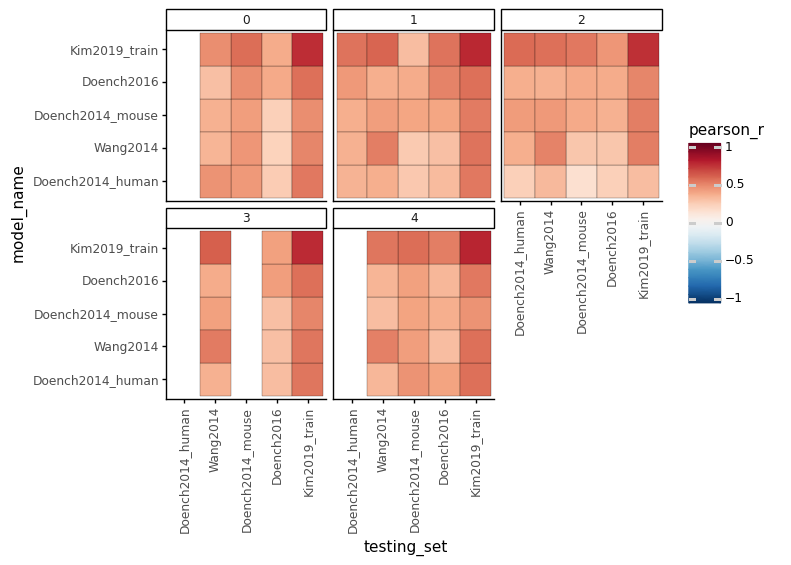

<ggplot: (8772448740901)>

In [14]:
plot_pearson_heatmap(single_predictive_performance)

We can see that the Kim training data outperforms all the rest, but it's also quite a bit bigger than the next biggest dataset

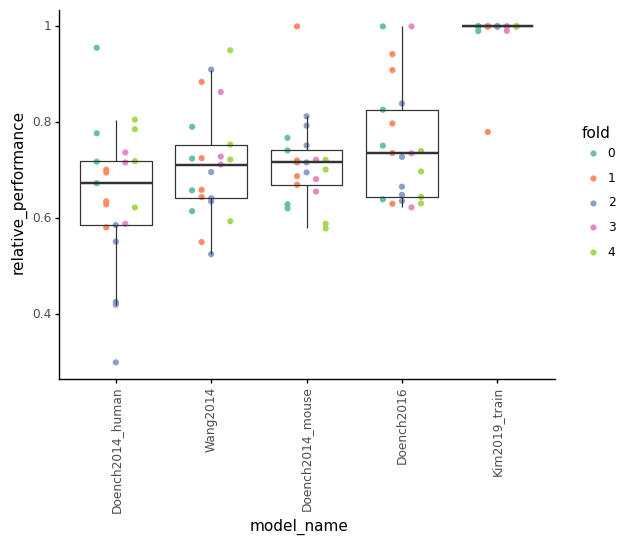

<ggplot: (8772479880915)>

In [15]:
plot_relative_performance(single_predictive_performance)


## Combining training datasets

If we merge the training datasets, can we improve our performance?
We'll merge by normalizing activity to a percent rank.

In [17]:
top_training_set = (single_predictive_performance.groupby('model_name')
                    .agg({'relative_performance': 'median'})
                    .reset_index()
                    .sort_values('relative_performance', ascending=False)
                    ['model_name']
                    .values[0])
print('Top training set: ' + top_training_set)

Top training set: Kim2019_train


In [19]:
combined_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: '+ str(fold))
    combined_test_prediction_list.extend(get_fold_predictions(fold, df, top_training_set=top_training_set))
    print('\n')

combined_predictive_performance = get_predictive_performance(combined_test_prediction_list)

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4




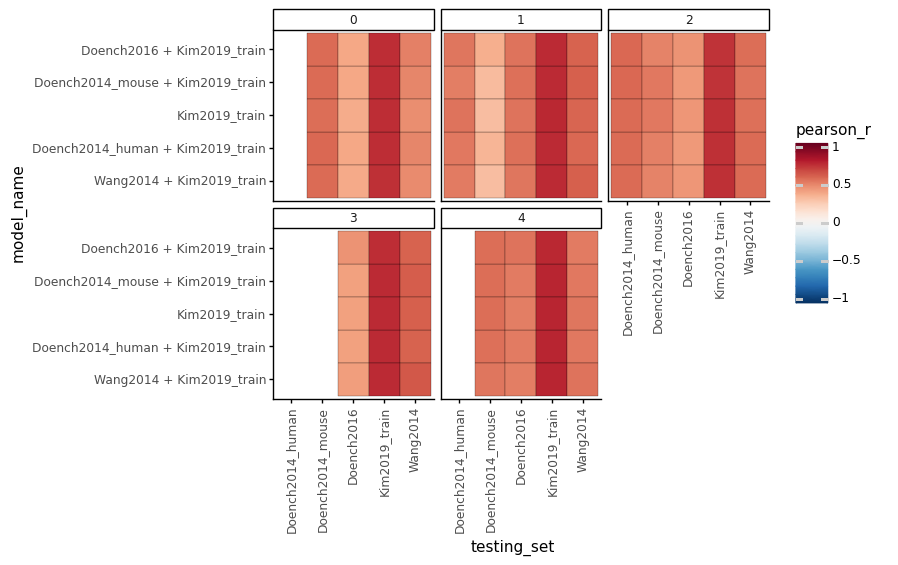

<ggplot: (8772397655378)>

In [20]:
plot_pearson_heatmap(combined_predictive_performance)

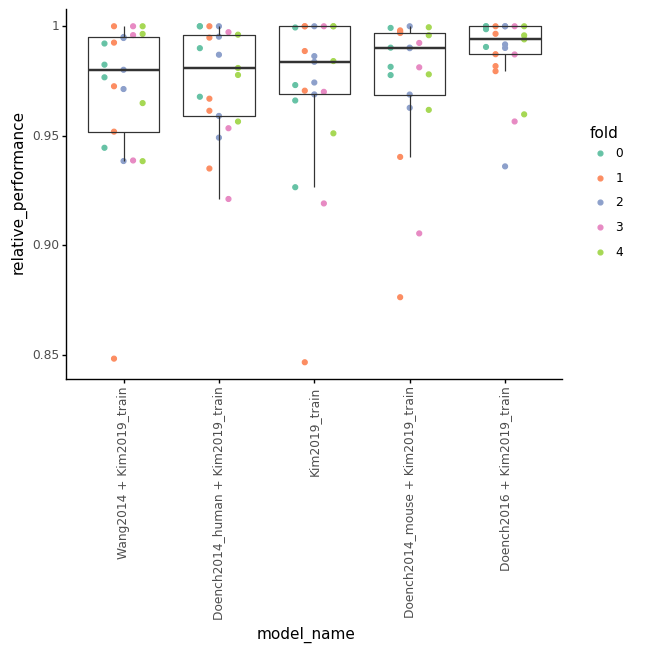

<ggplot: (8772412855706)>

In [21]:
plot_relative_performance(combined_predictive_performance)

We'll keep all training sets that don't significantly reduce predictive performance, which is all training sets

In [22]:
ttest_list = []
reference_scores = (combined_predictive_performance
                    .loc[combined_predictive_performance['model_name'] == top_training_set, 'pearson_r'])
for model_name, training_set_df in combined_predictive_performance.groupby('model_name'):
    compare_scores = training_set_df['pearson_r']
    t, p = stats.ttest_rel(reference_scores, compare_scores)
    ttest_list.append({'model_name': model_name, 't': t, 'p': p})
ttest_df = pd.DataFrame(ttest_list)
ttest_df.sort_values('t')

,model_name,t,p
4,Doench2016 + Kim2019_train,-1.481220,0.154132
3,Doench2014_mouse + Kim2019_train,-0.583353,0.566177
1,Doench2014_human + Kim2019_train,-0.355333,0.726060
0,Wang2014 + Kim2019_train,0.415258,0.682374
2,Kim2019_train,NaN,NaN


We'll try combining all datasets which don't significantly decrease performance

In [26]:
combine_datasets =  (ttest_df
    .loc[(ttest_df.t.fillna(0) < 0) | (ttest_df.p.fillna(1) > 0.05), 'model_name']
    .str.split(' \+ ', expand=True)[0])
print('Combine datasets: ' + ', '.join(combine_datasets))

Combine datasets: Wang2014, Doench2014_human, Kim2019_train, Doench2014_mouse, Doench2016


In [37]:
top_combined_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    top_combined_test_prediction_list.extend(get_fold_predictions(fold, df, combine_datasets=combine_datasets,
                                                                  model_name='All train data'))
    print('\n')

top_dual_model = ttest_df.sort_values('t')['model_name'].values[0]
print('Reference model: ' + str(top_dual_model))
top_dual_prediction_list = [df for df in combined_test_prediction_list if (df.model_name == top_dual_model).all()]
top_combined_predictive_performance = get_predictive_performance(top_combined_test_prediction_list +
                                                                 top_dual_prediction_list)

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4


Reference model: Doench2016 + Kim2019_train


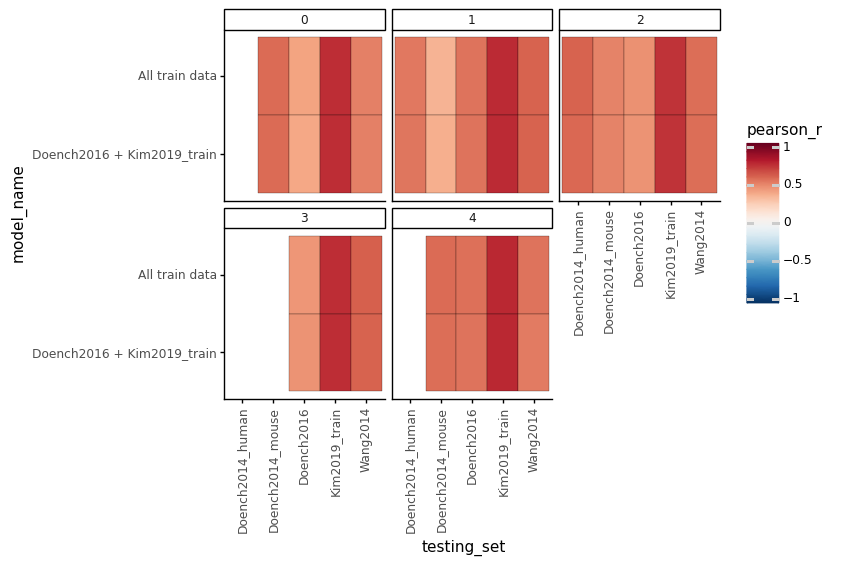

<ggplot: (8772448746978)>

In [39]:
plot_pearson_heatmap(top_combined_predictive_performance)

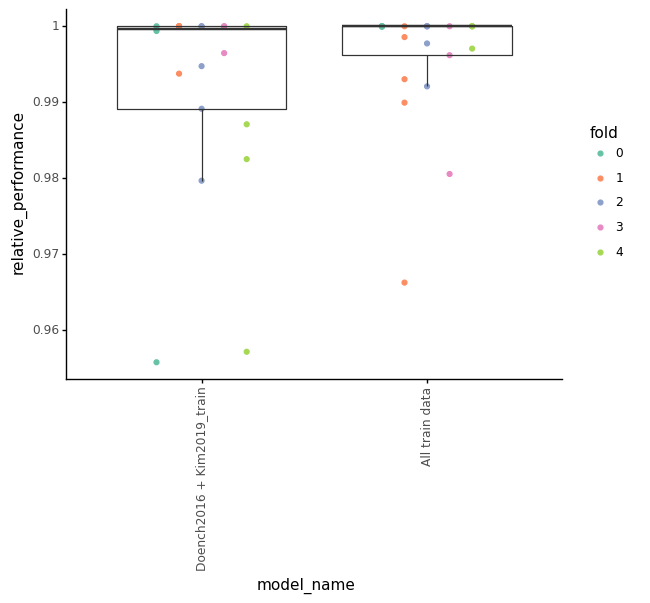

<ggplot: (8772397701253)>

In [40]:
plot_relative_performance(top_combined_predictive_performance)

## Sequence Model Hyperparameter Tuning

Using the combined datasets, we'll try different model architectures and use hyperparameter tuning.
For the hyperparmeter tuning, we'll use the [optuna library](https://optuna.readthedocs.io/en/stable/index.html),
which by default uses the Tree-structured Parzen Estimator to search the hyperparameter space.

In [38]:
n_trials = 40

### LightGBM

In [41]:
def get_lgbm_objective(fold_df):
    """Get objective function for training a lgbm model

    :param fold_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        # only doing train/test split
        train_index, test_index = next(sgkf.split(fold_df, fold_df.dataset, fold_df.target)) # just get first value
        train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
        train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                      ['sgRNA Activity']
                                      .rank(pct=True))
        X_train_val = sglearn.featurize_guides(train_df['sgRNA Context Sequence']) # train and validation data
        X_train_val.columns = X_train_val.columns.str.replace(',', '') # problem with lgbm regressor c code
        y_train_val = train_df['sgRNA Activity']
        num_leaves = trial.suggest_int('num_leaves', 2, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 2, 200)
        subsample = trial.suggest_float('subsample', 0.2, 1.0)
        subsample_freq = trial.suggest_int('subsample_freq', 1, 100)
        model = LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                              num_leaves=num_leaves,
                              min_child_samples=min_child_samples,
                              subsample=subsample, subsample_freq=subsample_freq)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                          test_size=0.1, random_state=7)
        model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=False)
        test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
        X_test = sglearn.featurize_guides(test_df['sgRNA Context Sequence'])
        X_test.columns = X_test.columns.str.replace(',', '')
        test_predictions = test_df.copy()
        test_predictions['prediction'] = model.predict(X_test)
        test_predictions['sgRNA Activity'] = (test_predictions.groupby('dataset')
                                              ['sgRNA Activity']
                                              .rank(pct=True))
        r2 = r2_score(test_predictions['sgRNA Activity'], test_predictions['prediction'])
        return r2
    return objective

In [42]:
lgbm_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize') # maximize r^2
    objective = get_lgbm_objective(fold_train_data)
    study.optimize(objective, n_trials=n_trials)
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset
    train_df = fold_train_data.copy()
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    X_train_val = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    X_train_val.columns = X_train_val.columns.str.replace(',', '')
    y_train_val = train_df['sgRNA Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                          **trial.params)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=1000)
    # Test optimal model on test data
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = sglearn.featurize_guides(fold_test_data['sgRNA Context Sequence'])
    X_test.columns = X_test.columns.str.replace(',', '')
    test_predictions = fold_test_data.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['model_name'] = 'All train data + LGBM + TPE' + str(n_trials)
    test_predictions['fold'] = fold
    lgbm_prediction_list.append(test_predictions)

[I 2021-04-07 17:09:59,964] A new study created in memory with name: no-name-27f78cbc-c69f-405d-af52-d1ec4377fc1b
[I 2021-04-07 17:10:11,314] Trial 0 finished with value: 0.464320177477603 and parameters: {'num_leaves': 38, 'min_child_samples': 150, 'subsample': 0.37083035234413597, 'subsample_freq': 29}. Best is trial 0 with value: 0.464320177477603.
[I 2021-04-07 17:10:23,824] Trial 1 finished with value: 0.5004026857658073 and parameters: {'num_leaves': 54, 'min_child_samples': 53, 'subsample': 0.9728034043555844, 'subsample_freq': 48}. Best is trial 1 with value: 0.5004026857658073.
[I 2021-04-07 17:10:36,471] Trial 2 finished with value: 0.4918362682773547 and parameters: {'num_leaves': 231, 'min_child_samples': 88, 'subsample': 0.7757306964950457, 'subsample_freq': 54}. Best is trial 1 with value: 0.5004026857658073.
[I 2021-04-07 17:10:48,617] Trial 3 finished with value: 0.49569539350577363 and parameters: {'num_leaves': 212, 'min_child_samples': 140, 'subsample': 0.73353598378

Fold: 0
Number of finished trials: 40
Best trial:
  Value: 0.5039921807598721
  Params: 
    num_leaves: 20
    min_child_samples: 144
    subsample: 0.9896523703309432
    subsample_freq: 42
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.0455856
[2000]	valid_0's l2: 0.0435367
Early stopping, best iteration is:
[2267]	valid_0's l2: 0.0431941
Fold: 1
Number of finished trials: 40
Best trial:
  Value: 0.4854211353920317
  Params: 
    num_leaves: 38
    min_child_samples: 96
    subsample: 0.913669038791939
    subsample_freq: 1
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.0452469
Early stopping, best iteration is:
[1544]	valid_0's l2: 0.0442183
Fold: 2
Number of finished trials: 40
Best trial:
  Value: 0.4220500141818624
  Params: 
    num_leaves: 39
    min_child_samples: 76
    subsample: 0.6270769239960771
    subsample_freq: 1
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 

In [43]:
lgbm_predictive_performance = get_predictive_performance(top_combined_test_prediction_list +
                                                         lgbm_prediction_list)

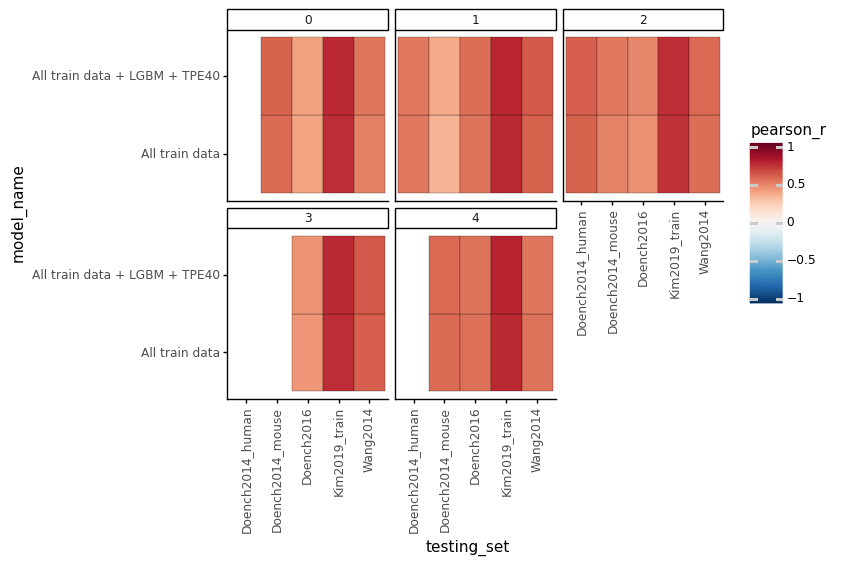

<ggplot: (8772371866275)>

In [44]:
plot_pearson_heatmap(lgbm_predictive_performance)

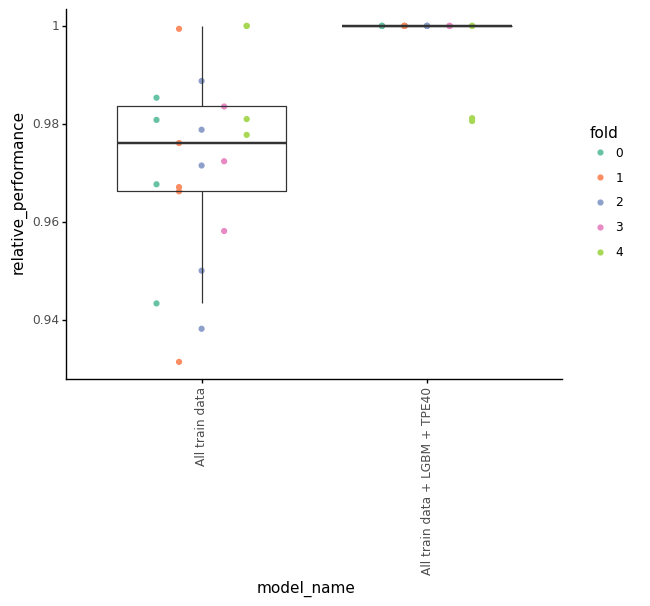

<ggplot: (8772443776567)>

In [45]:
plot_relative_performance(lgbm_predictive_performance)
